В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [138]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [139]:
df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv')

Перевіряю чи є пропущенні значення у даних. 

In [140]:
df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [142]:
X = df.drop('Exited', axis=1)
y = df[['Exited']]

In [143]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, stratify=y, random_state=29)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [144]:
input_cols = X_train.columns.to_list
target_col = y_train.columns.to_list

In [145]:
train_inputs, train_targets, val_inputs, val_targets = X_train, y_train, X_validation, y_validation

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [146]:
numeric_cols = train_inputs.select_dtypes(['int64', 'float64']).columns.to_list()
categorical_cols = train_inputs.select_dtypes('object').columns.to_list()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти передобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

Масштабування числових ознак:

In [147]:
scaler = MinMaxScaler()

In [148]:
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [149]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

Пропущених значень немає.

Кодування категоріальних ознак. Спершу перевірю які дані містять категоріальні ознаки.

In [150]:
train_inputs[categorical_cols].head(5)

,Surname,Geography,Gender
6410,Mazzanti,France,Male
4810,Chinwendu,France,Female
980,Trevisano,France,Male
2603,Young,France,Female
11458,Tsao,France,Female


Дізнаюсь яка кількість унікальних значень є у кожної ознаки:

In [151]:
train_inputs[categorical_cols].nunique()

Surname      731
Geography      3
Gender         2
dtype: int64

Аналіз колонки `Surname`

In [152]:
train_inputs.Surname.value_counts(ascending=False).head(10)

Surname
Ch'iu     210
Ch'ien    200
Ch'ang    175
Hsia      161
T'ien     149
Hsueh     130
Ch'in     121
Shih      121
Hs?       120
Kao       118
Name: count, dtype: int64

In [153]:
train_inputs.Surname.value_counts(ascending=True).head(10)

Surname
Pomeroy      1
Tipton       1
Burdekin     1
Hung         1
Rios         1
Riggs        1
Rueda        1
Azikiwe      1
Longstaff    1
Koo          1
Name: count, dtype: int64

In [154]:
# Підрахунок частоти кожного прізвища
surname_counts = train_inputs.Surname.value_counts()

# Відбір прізвищ, які з'являються лише один раз
unique_surnames = surname_counts[surname_counts < 10]

# Кількість прізвищ, які з'являються лише один раз
len(unique_surnames)

446

Унікальних значень у колонці `Surname` є 731, що наче виглядає не багато для загальної кількості рядків 15000, але також бачу, що прізвищ, які повторюються менше 10 раз є 446 від загальної кількості 731. Тому приймаю рішення видалити колонку `Surname`. 

In [155]:
train_inputs.drop('Surname', axis=1, inplace=True)
val_inputs.drop('Surname', axis=1, inplace=True)
categorical_cols.remove('Surname')

Кодування колонки `Geography`. Для цього використовую `OneHotEncoder`

In [156]:
encoder = OneHotEncoder(sparse_output=False)

In [157]:
encoder.fit(train_inputs[['Geography']])

OneHotEncoder(sparse_output=False)

In [158]:
encoded_cols = list(encoder.get_feature_names_out())
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain']


In [159]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[['Geography']])
val_inputs[encoded_cols] = encoder.transform(val_inputs[['Geography']])

Кодування колонки `Gender`.

In [160]:
X_train.Gender.value_counts()

Gender
Male      6861
Female    5139
Name: count, dtype: int64

In [161]:
Gender_codes = {'Female': 0, 'Male': 1}

train_inputs['Is_Male'] = train_inputs.Gender.map(Gender_codes)
val_inputs['Is_Male'] = val_inputs.Gender.map(Gender_codes)

In [162]:
display(train_inputs.head(5))

,id,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Is_Male
6410,0.427362,0.197913,0.377088,France,Male,0.375000,0.5,0.0,0.333333,0.0,1.0,0.276969,1.0,0.0,0.0,1
4810,0.320688,0.100752,0.365155,France,Female,0.339286,0.9,0.0,0.333333,0.0,0.0,0.359127,1.0,0.0,0.0,0
980,0.065338,0.410370,0.412888,France,Male,0.267857,0.5,0.0,0.333333,1.0,0.0,0.398942,1.0,0.0,0.0,1
2603,0.173545,0.772482,0.577566,France,Female,0.267857,0.1,0.0,0.333333,1.0,1.0,0.914365,1.0,0.0,0.0,0
11458,0.763918,0.979015,0.042959,France,Female,0.375000,0.9,0.0,0.333333,1.0,0.0,0.414822,1.0,0.0,0.0,0


In [163]:
display(val_inputs.head(5))

,id,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Is_Male
5274,0.351623,0.422211,0.398568,France,Female,0.607143,0.4,0.000000,0.000000,1.0,1.0,0.659602,1.0,0.0,0.0,0
3693,0.246216,0.436687,0.391408,France,Male,0.357143,0.3,0.000000,0.333333,1.0,0.0,0.456716,1.0,0.0,0.0,1
4837,0.322488,0.798419,0.527446,France,Male,0.303571,0.5,0.000000,0.333333,1.0,1.0,0.629810,1.0,0.0,0.0,1
2544,0.169611,0.129018,0.828162,France,Female,0.339286,0.2,0.520277,0.333333,0.0,1.0,0.241857,1.0,0.0,0.0,0
13206,0.880459,0.113093,0.673031,Spain,Female,0.357143,0.6,0.000000,0.333333,1.0,0.0,0.714210,0.0,0.0,1.0,0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [164]:
train_inputs.to_parquet('bank-customer-churn-prediction-dlu/train_inputs.parquet')
train_targets.to_parquet('bank-customer-churn-prediction-dlu/train_targets.parquet')
val_inputs.to_parquet('bank-customer-churn-prediction-dlu/val_inputs.parquet')
val_targets.to_parquet('bank-customer-churn-prediction-dlu/val_targets.parquet')

In [165]:
os.listdir('bank-customer-churn-prediction-dlu')

['log_reg.joblib',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхідних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [166]:
train_inputs.head()

,id,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Is_Male
6410,0.427362,0.197913,0.377088,France,Male,0.375000,0.5,0.0,0.333333,0.0,1.0,0.276969,1.0,0.0,0.0,1
4810,0.320688,0.100752,0.365155,France,Female,0.339286,0.9,0.0,0.333333,0.0,0.0,0.359127,1.0,0.0,0.0,0
980,0.065338,0.410370,0.412888,France,Male,0.267857,0.5,0.0,0.333333,1.0,0.0,0.398942,1.0,0.0,0.0,1
2603,0.173545,0.772482,0.577566,France,Female,0.267857,0.1,0.0,0.333333,1.0,1.0,0.914365,1.0,0.0,0.0,0
11458,0.763918,0.979015,0.042959,France,Female,0.375000,0.9,0.0,0.333333,1.0,0.0,0.414822,1.0,0.0,0.0,0


Видалю колонки, які були трансформовані(`Geography` та `Gender`), а також `id` та `CustomerId`, оскільки ці дані не матимуть сенсу для моделі.

In [167]:
columns_for_train = train_inputs.drop(['id', 'CustomerId', 'Geography', 'Gender'], axis=1).columns.to_list()

In [168]:
X_train, X_val = train_inputs[columns_for_train], val_inputs[columns_for_train]

Перевіряю чи коректно видалились колонки.

In [169]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Is_Male
6410,0.377088,0.375000,0.5,0.0,0.333333,0.0,1.0,0.276969,1.0,0.0,0.0,1
4810,0.365155,0.339286,0.9,0.0,0.333333,0.0,0.0,0.359127,1.0,0.0,0.0,0
980,0.412888,0.267857,0.5,0.0,0.333333,1.0,0.0,0.398942,1.0,0.0,0.0,1
2603,0.577566,0.267857,0.1,0.0,0.333333,1.0,1.0,0.914365,1.0,0.0,0.0,0
11458,0.042959,0.375000,0.9,0.0,0.333333,1.0,0.0,0.414822,1.0,0.0,0.0,0


In [170]:
X_val.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Is_Male
5274,0.398568,0.607143,0.4,0.000000,0.000000,1.0,1.0,0.659602,1.0,0.0,0.0,0
3693,0.391408,0.357143,0.3,0.000000,0.333333,1.0,0.0,0.456716,1.0,0.0,0.0,1
4837,0.527446,0.303571,0.5,0.000000,0.333333,1.0,1.0,0.629810,1.0,0.0,0.0,1
2544,0.828162,0.339286,0.2,0.520277,0.333333,0.0,1.0,0.241857,1.0,0.0,0.0,0
13206,0.673031,0.357143,0.6,0.000000,0.333333,1.0,0.0,0.714210,0.0,0.0,1.0,0


In [171]:
model = LogisticRegression(solver='liblinear', random_state=29)

In [172]:
model.fit(train_inputs[columns_for_train], train_targets)

LogisticRegression(random_state=29, solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Визначення функції для розрахунку Accuracy та побудови Confusion matrix.

In [173]:
def predict_f1_and_matrix_plot(inputs, targets, preds, name=''):
    #Отримання прогнозів моделі
    train_preds = model.predict(preds)

    #Обчислення точності моделі
    accuracy = accuracy_score(targets, train_preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    #Обчислення F1-score
    f1_sc = f1_score(targets, train_preds, pos_label=1)
    print("F1-score: {:.2f}".format(f1_sc))
    
    #Побудова та візуалізація матриці плутанини
    cf_m = confusion_matrix(targets, train_preds, normalize='true')
    plt.figure()
    sns.heatmap(cf_m, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.29%
F1-score: 0.63


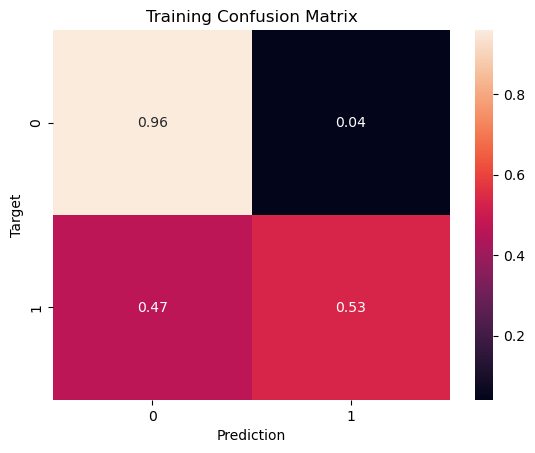

In [174]:
train_preds = predict_f1_and_matrix_plot(train_inputs, train_targets, train_inputs[columns_for_train], 'Training')

Accuracy: 87.27%
F1-score: 0.63


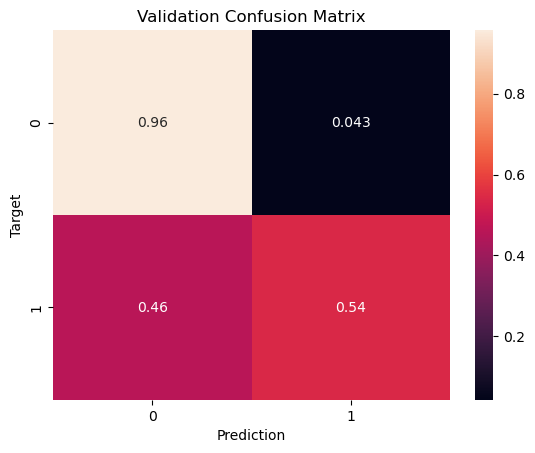

In [175]:
train_preds = predict_f1_and_matrix_plot(val_inputs, val_targets, val_inputs[columns_for_train], 'Validation')

Визначення функції для розрахунку метрики AUROC та побудови ROC Curve.

In [176]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
    # Отримання ймовірностей
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # Обчислення ROC-кривої
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)

    # Обчислення AUROC
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.2f}')
    
    # Побудова кривої ROC
    plt.figure()
    plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

AUROC for Training: 0.88


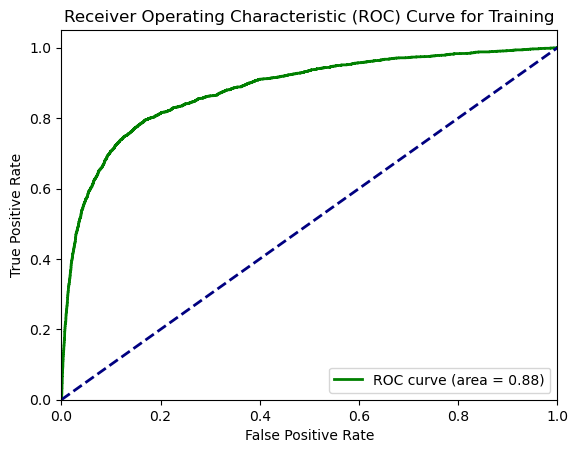

AUROC for Validation: 0.89


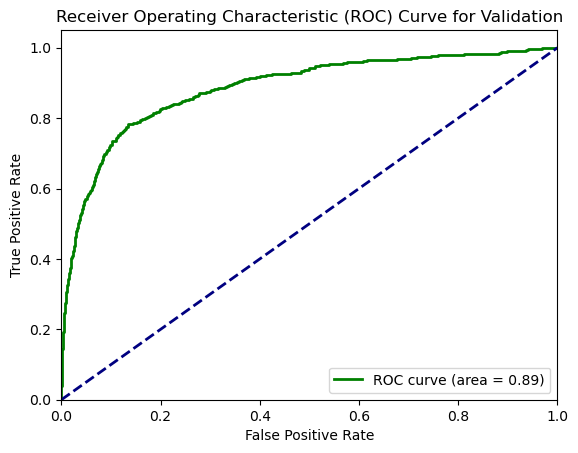

In [177]:
compute_auroc_and_build_roc(train_inputs[columns_for_train], train_targets, 'Training')
compute_auroc_and_build_roc(val_inputs[columns_for_train], val_targets, 'Validation')

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [178]:
majority_class = train_targets.value_counts().idxmax()[0]

In [179]:
majority_predictions = np.full_like(train_targets, fill_value=majority_class)

In [180]:
#Обчислення точності моделі, яка передбачає завжди мажоритарний клас
accuracy = accuracy_score(train_targets, majority_predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 79.65%


Accuracy моделі, яка передбачає завжди мажоритарний клас: 79.65% 

Accuracy натренованої вище моделі: 87.29%

**Висновок:** Натренована модель дає кращі результати, ніж модель, що завжди передбачає мажоритарний клас. 

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [181]:
log_reg = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [182]:
joblib.dump(log_reg, 'bank-customer-churn-prediction-dlu/log_reg.joblib')

['bank-customer-churn-prediction-dlu/log_reg.joblib']

In [183]:
log_reg2 = joblib.load('bank-customer-churn-prediction-dlu/log_reg.joblib')

In [184]:
model_2 = log_reg2['model']

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [251]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols]) 
    input_df[encoded_cols] = encoder.transform(input_df[['Geography']])
    
    Gender_codes = {'Female': 0, 'Male': 1}
    input_df['Is_Male'] = input_df.Gender.map(Gender_codes)
    
    X_input = input_df[numeric_cols + encoded_cols + ['Is_Male']]
    
    columns_for_train = X_input.drop(['id', 'CustomerId'], axis=1).columns.to_list()
    
    X_input = input_df[columns_for_train]
    prob = model.predict_proba(X_input)[:,1]
    
    return prob

In [255]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, df[:5])

array([0.00698981, 0.03552056, 0.36007702, 0.37254884, 0.97498163])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [256]:
test_raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/test.csv')

In [257]:
test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [266]:
sample_submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv')

In [268]:
sample_submission['Exited'] = test_raw_df['Exited']

In [270]:
sample_submission.head()

,id,Exited
0,15000,0.079955
1,15001,0.033662
2,15002,0.148411
3,15003,0.183456
4,15004,0.054029


In [271]:
sample_submission.to_csv('bank-customer-churn-prediction-dlu/submission_log_reg.csv', index=False)